I encountered some errors when rerunning everything, the following code is exactly what I used to get the kaggle score

# Libraries

In [5]:
pip install --upgrade scikit-learn imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.9.1
    Uninstalling imbalanced-learn-0.9.1:
      Successfully uninstalled imbalanced-learn-0.9.1
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install textblob

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

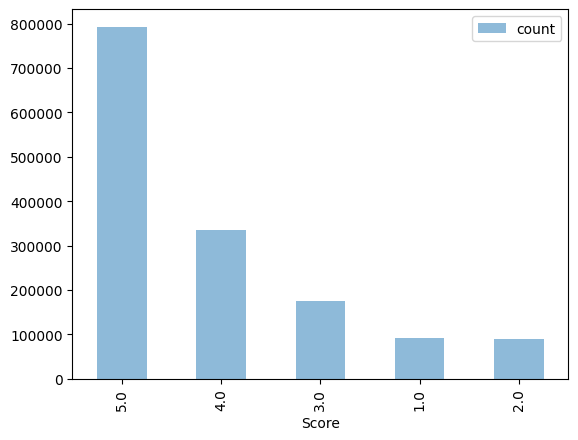


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [12]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Resampling

In [13]:
"""from imblearn.over_sampling import RandomOverSampler

# Define the oversampler
oversampler = RandomOverSampler(random_state=42)

# Apply the oversampler to your training data
X_resampled, y_resampled = oversampler.fit_resample(X_train_select, Y_train_int)

# Check the new class distribution
print("Resampled class distribution:", dict(pd.Series(y_resampled).value_counts()))
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()"""

'from imblearn.over_sampling import RandomOverSampler\n\n# Define the oversampler\noversampler = RandomOverSampler(random_state=42)\n\n# Apply the oversampler to your training data\nX_resampled, y_resampled = oversampler.fit_resample(X_train_select, Y_train_int)\n\n# Check the new class distribution\nprint("Resampled class distribution:", dict(pd.Series(y_resampled).value_counts()))\ntrainingSet[\'Score\'].value_counts().plot(kind=\'bar\', legend=True, alpha=.5)\nplt.show()'

Helper Functions:

In [14]:
from joblib import Parallel, delayed

analyzer = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound'], scores['pos'], scores['neg'], scores['neu']

# Define a function that applies TextBlob's sentiment analysis
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity


# Adding Features

In [15]:
def add_features_to(df):
    # This is where you can do all your feature extraction
    # Calculate Helpfulness and handle missing values
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    mean_helpfulness = df['Helpfulness'].mean()
    df['Helpfulness'] = df['Helpfulness'].fillna(mean_helpfulness)
    
    # Ensure 'Text' is a string and fill missing values with an empty string
    df['Text'] = df['Text'].fillna('').astype(str)
    df['Summary'] = df['Summary'].fillna('').astype(str)
    
    # Calculate the length of the comment in characters and words
    #df['CommentLength_Chars'] = df['Text'].apply(len)
    
    # Add the average score for each ProductId directly into the original dataframe
    df['AverageMovieScore'] = df.groupby('ProductId')['Score'].transform('mean')
    # Fill missing values in AverageMovieScore with the overall mean of the 'Score' column
    df['AverageMovieScore'] = df['AverageMovieScore'].fillna(df['Score'].mean())

    # Add the average score for each ProductId directly into the original dataframe
    df['AverageUserScore'] = df.groupby('UserId')['Score'].transform('mean')
    # Fill missing values in AverageUserScore with the overall mean of the 'Score' column
    df['AverageUserScore'] = df['AverageUserScore'].fillna(df['Score'].mean())

    # Calculate how users rate certain products compared to the average score for that product.
    df['UserDeviationFromProductAvg'] = df['Score'] - df['AverageMovieScore']

    #df['AfinnScore'] = trainingSet['Text'].apply(afinn.score)

    # Use parallel processing for sentiment analysis
    vaderSentiment = Parallel(n_jobs=-1)(delayed(sentiment_scores)(str(text)) for text in df['Text'])
    df[['Sentiment_Compound', 'Sentiment_Positive', 'Sentiment_Negative', 'Sentiment_Neutral']] = pd.DataFrame(vaderSentiment, index=df.index)

    textblobSentiment = Parallel(n_jobs=-1)(delayed(analyze_sentiment)(text) for text in df['Text'])
    # Unpack the polarity and subjectivity values and assign them to new DataFrame columns
    df['Text_Polarity'], df['Text_Subjectivity'] = zip(*textblobSentiment)

    # Similarly, apply the sentiment analysis to the 'Summary' column
    summarySentiment = Parallel(n_jobs=-1)(delayed(analyze_sentiment)(summary) for summary in df['Summary'])

    # Unpack the polarity and subjectivity values for the 'Summary' column
    df['Summary_Polarity'], df['Summary_Subjectivity'] = zip(*summarySentiment)

    # Min-Max normalization for selected columns
    scaler = MinMaxScaler()
    # Choose the columns you want to normalize
    columns_to_normalize = ['Helpfulness', 'Sentiment_Compound', 'AverageMovieScore','AverageUserScore','Time','UserDeviationFromProductAvg','Sentiment_Positive','Sentiment_Negative','Sentiment_Neutral'
                            ,'HelpfulnessNumerator', 'HelpfulnessDenominator','Text_Polarity','Text_Subjectivity','Summary_Polarity','Summary_Subjectivity']
    # Apply Min-Max scaling
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    # Return the original DataFrame with features and the average score DataFrame
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Correlation Matrix

In [16]:
print(X_train.columns)

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'AverageMovieScore', 'AverageUserScore',
       'UserDeviationFromProductAvg', 'Sentiment_Compound',
       'Sentiment_Positive', 'Sentiment_Negative', 'Sentiment_Neutral',
       'Text_Polarity', 'Text_Subjectivity', 'Summary_Polarity',
       'Summary_Subjectivity'],
      dtype='object')


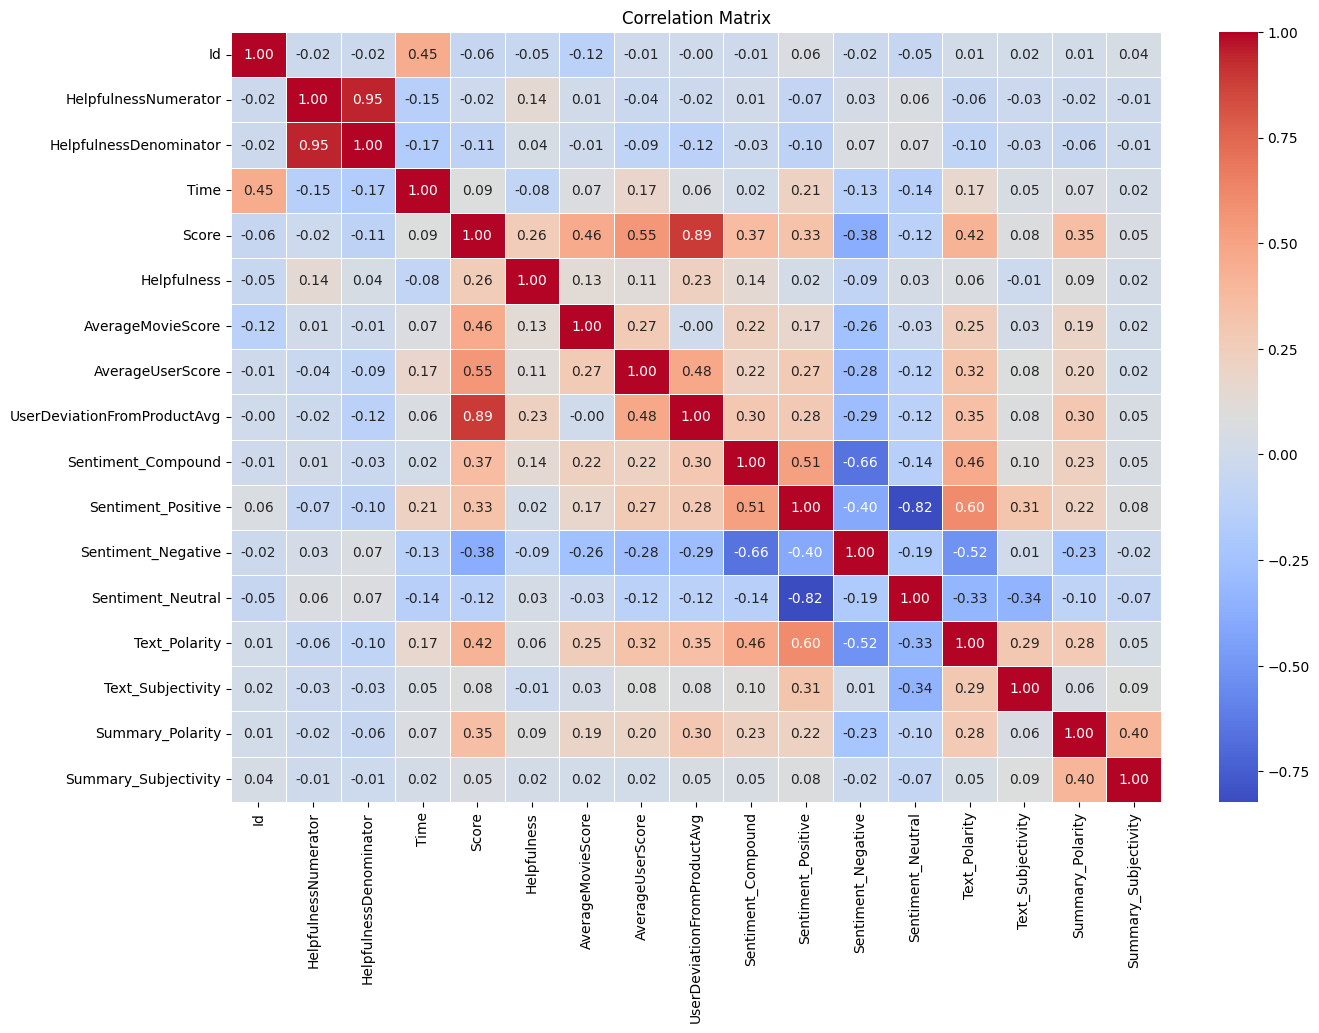

In [27]:
# Compute and display the correlation matrix
def plot_correlation_matrix(df):
    numeric_df = df.select_dtypes(include=[float, int])
    plt.figure(figsize=(15, 10))
    correlation_matrix = numeric_df.corr()  # Calculate correlation matrix
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

# Plot the correlation matrix for the training set (X_train)
plot_correlation_matrix(train)


# Sample + Split into training and testing set

In [19]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/5.0,
    random_state=0
)

# Feature Selection

In [20]:
features = ['Helpfulness','Time','Sentiment_Compound','Sentiment_Positive','Sentiment_Negative','Sentiment_Neutral','HelpfulnessNumerator', 'HelpfulnessDenominator','AverageMovieScore','AverageUserScore','Text_Polarity','Text_Subjectivity','Summary_Polarity','Summary_Subjectivity']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation (XGBoost)

In [ ]:
"""# Learn the model
knn_model = KNeighborsClassifier(n_neighbors=11).fit(X_train_select, Y_train)

# Predict the score using the model
#Y_test_predictions = model.predict(X_test_select)"""

In [ ]:
# Finding best parameter for xgboost
"""from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint

# If X_test_select is a pandas DataFrame or Series, convert it to a NumPy array
if isinstance(X_test_select, pd.DataFrame) or isinstance(X_test_select, pd.Series):
    X_test_select = X_test_select.to_numpy()

# Ensure that Y_train is converted to integers as needed
Y_train_int = (Y_train - 1).astype(int)

# Convert X_train_select to numpy if it is not already
if isinstance(X_train_select, pd.DataFrame) or isinstance(X_train_select, pd.Series):
    X_train_select = X_train_select.to_numpy()

# Ensure that Y_train_int is also a numpy array
if isinstance(Y_train_int, pd.DataFrame) or isinstance(Y_train_int, pd.Series):
    Y_train_int = Y_train_int.to_numpy()
    
# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.5, 1.5)
}

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(random_state=42)

# Perform random search with cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42)

# Fit the model
random_search.fit(X_train_select, Y_train_int)

# Print the best hyperparameters
print("Best hyperparameters:", random_search.best_params_)





# Use the best model
best_model = random_search.best_estimator_

# Predict the test set
Y_test_predictions = best_model.predict(X_test_select)
# If needed, add 1 back to the predictions to match the original label set
Y_test_predictions = Y_test_predictions + 1"""


In [21]:
# training model with XGboost
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV



# If X_test_select is a pandas DataFrame or Series, convert it to a NumPy array
if isinstance(X_test_select, pd.DataFrame) or isinstance(X_test_select, pd.Series):
    X_test_select = X_test_select.to_numpy()

# Ensure that Y_train is converted to integers as needed
Y_train_int = (Y_train - 1).astype(int)

# Convert X_train_select to numpy if it is not already
if isinstance(X_train_select, pd.DataFrame) or isinstance(X_train_select, pd.Series):
    X_train_select = X_train_select.to_numpy()

# Ensure that Y_train_int is also a numpy array
if isinstance(Y_train_int, pd.DataFrame) or isinstance(Y_train_int, pd.Series):
    Y_train_int = Y_train_int.to_numpy()




"""# Balancing data
# Get the unique classes and their counts
classes, class_counts = np.unique(Y_train_int, return_counts=True)
# Compute the class weights (inverse of class frequencies)
class_weights = compute_class_weight('balanced', classes=classes, y=Y_train_int)
# Create a dictionary mapping each class to its weight
class_weight_dict = dict(zip(classes, class_weights))
# Assign sample weights based on the class weights
sample_weights = np.array([class_weight_dict[label] for label in Y_train_int])"""


best_params = {
    'colsample_bytree': 0.8455839622828947,
    'gamma': 0.18634343354702465,
    'learning_rate': 0.08893829336189445,
    'max_depth': 8,
    'min_child_weight': 3,
    'n_estimators': 459,
    'reg_alpha': 0.0704161308495439,
    'reg_lambda': 0.8133780764230403,
    'subsample': 0.9013430550472151,
    'random_state': 42  # Ensure reproducibility
}

# Initialize XGBoost with best_params
xgb_model = xgb.XGBClassifier(**best_params)

# Fit the model with the sample weights (balanced)
#xgb_model.fit(X_train_select, Y_train_int, sample_weight=sample_weights)


from imblearn.over_sampling import SMOTE

# Define the SMOTE oversampler with sampling strategy for classes 1, 2, and 3
#smote = SMOTE(sampling_strategy={
#    0: int(len(Y_train_int[Y_train_int == 4]) * 0.4),
#    1: int(len(Y_train_int[Y_train_int == 4]) * 0.4),  # Set class 1 to 40% of class 4
#    2: int(len(Y_train_int[Y_train_int == 4]) * 0.5),  # Set class 2 to 60% of class 4
#    3: int(len(Y_train_int[Y_train_int == 4]) * 0.7),  # Set class 3 to 80% of class 4
#}, random_state=42)
# Apply SMOTE to your training data
#X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_select, Y_train_int)

# oversampling fit
#xgb_model.fit(X_train_resampled, Y_train_resampled)

# if not using combined model, run the following line
xgb_model.fit(X_train_select, Y_train_int)

# Make predictions on the test set
Y_test_predictions = xgb_model.predict(X_test_select)

# If needed, add 1 back to the predictions to match the original label set
Y_test_predictions = Y_test_predictions + 1

In [ ]:
"""# If X_test_select is a pandas DataFrame or Series, convert it to a NumPy array
if isinstance(X_test_select, pd.DataFrame) or isinstance(X_test_select, pd.Series):
    X_test_select = X_test_select.to_numpy()

# Ensure that Y_train is converted to integers as needed
Y_train_int = (Y_train - 1).astype(int)

# Ensure that Y_train is converted to integers as needed
#Y_train_int = Y_train.astype(int)

# Convert X_train_select to numpy if it is not already
if isinstance(X_train_select, pd.DataFrame) or isinstance(X_train_select, pd.Series):
    X_train_select = X_train_select.to_numpy()

# Ensure that Y_train_int is also a numpy array
if isinstance(Y_train_int, pd.DataFrame) or isinstance(Y_train_int, pd.Series):
    Y_train_int = Y_train_int.to_numpy()"""

# Run XGBoost with default parameters

In [ ]:
"""import xgboost as xgb
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train_select, Y_train_int)
# Make predictions on the test set
Y_test_predictions = model.predict(X_test_select)

# If needed, add 1 back to the predictions to match the original label set
#Y_test_predictions = Y_test_predictions + 1"""


# Random Forest

In [ ]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Check the class distribution before SMOTE (if using SMOTE)
print("Class distribution before SMOTE:", Counter(Y_train_int))

# Optionally, apply SMOTE if you still want to oversample
# smote = SMOTE(sampling_strategy={1: int(len(Y_train_int[Y_train_int == 4]) * 0.6),
#                                  2: int(len(Y_train_int[Y_train_int == 4]) * 0.6),
#                                  3: int(len(Y_train_int[Y_train_int == 4]) * 0.8)}, random_state=42)
# X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_select, Y_train_int)

# Alternatively, you can fit directly on the original data and use class_weight='balanced'
# Create and fit the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fit the model (if using resampled data)
# rf_model.fit(X_train_resampled, Y_train_resampled)

# If not using SMOTE, fit the model on the original data
rf_model.fit(X_train_select, Y_train_int)

# Predict on the test set
Y_test_predictions = rf_model.predict(X_test_select)"""

# Fitting Model with combined models

In [ ]:
"""# Fit KNN and XGBoost models separately
knn_model.fit(X_train_select, Y_train_int)
xgb_model.fit(X_train_select, Y_train_int)

# Get predictions from both models
knn_preds = knn_model.predict(X_test_select)
xgb_preds = xgb_model.predict(X_test_select)

# Combine predictions by averaging
Y_test_predictions = (knn_preds + xgb_preds) / 2

# If needed, add 1 back to the predictions to match the original label set
Y_test_predictions = Y_test_predictions + 1"""

In [70]:
"""from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=11)

# Create a StackingClassifier with parallel processing enabled
stacking_model = StackingClassifier(
    estimators=[('xgb', xgb_model), ('knn', knn_model)], 
    final_estimator=xgb.XGBClassifier(n_jobs=-1),  # You can also parallelize the final estimator
    n_jobs=-1  # Enables parallel processing of the base models
)

# Fit the stacking model
stacking_model.fit(X_train_select, Y_train_int)

# Predict on the test set
Y_test_predictions = stacking_model.predict(X_test_select)

Y_test_predictions = Y_test_predictions + 1"""

# Model Evaluation

In [ ]:
"""Y_test_predictions = np.round(Y_test_predictions).astype(int)
print(Y_test_predictions)"""

Accuracy on testing set =  0.6499937724905661


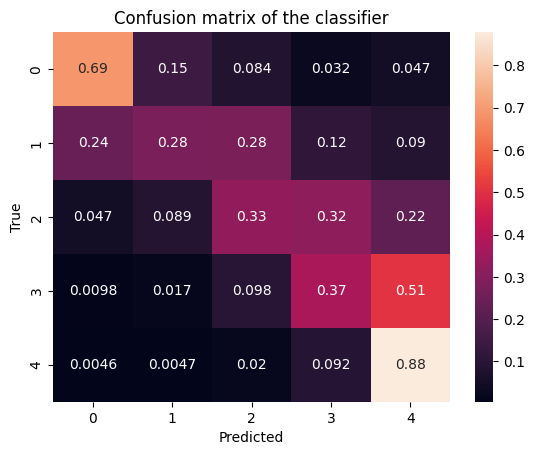

In [22]:
# Evaluate your model on the testing set

print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Create submission file

In [73]:
# Create the submission file
X_submission['Score'] = xgb_model.predict(X_submission_select) + 1
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

In [ ]:
print(submission['Score'].max())

print(submission['Score'].min())

print(submission['Score'])